In [13]:
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c ieee-fraud-detection

Saving kaggle.json to kaggle (1).json
 90% 47.0M/52.5M [00:00<00:00, 101MB/s] 
100% 52.5M/52.5M [00:00<00:00, 131MB/s]
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 99.1MB/s]
 82% 39.0M/47.3M [00:00<00:00, 105MB/s] 
100% 47.3M/47.3M [00:00<00:00, 134MB/s]
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 96.7MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 164MB/s]


Now we need to "unzip" the downloaed files. This is done with the following 5 commands

In [19]:
!unzip sample_submission.csv.zip
!unzip train_transaction.csv.zip
!unzip train_identity.csv.zip
!unzip test_transaction.csv.zip
!unzip test_identity.csv.zip



Archive:  sample_submission.csv.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  train_transaction.csv.zip
replace train_transaction.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Archive:  train_identity.csv.zip
  inflating: train_identity.csv      
Archive:  test_transaction.csv.zip
  inflating: test_transaction.csv    
Archive:  test_identity.csv.zip
  inflating: test_identity.csv       


The size of the data here is pretty big, so in order to handle it, there are some tricks that we can in order to save memory. This function does just that, by looking at the columns and sees is the minimum and maximum values can fit into int16, int32 or int64 or float16, float32 or float64.

In [0]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

First we import our dependencies in Python

In [0]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


from sklearn.preprocessing import StandardScaler  

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

Now it is time to load the .csv files into memory. We do this we the pandas command read_csv and after loading them, we apply the defined reduce_mem_usage() function above to use as small of a int/float as possible. Please be aware - the function takes roughly 5 minutes to run.

In [20]:
%%time
train_identity = pd.read_csv('~/train_identity.csv')
train_identity = reduce_mem_usage(train_identity)
test_identity = pd.read_csv('~/test_identity.csv')
test_identity = reduce_mem_usage(test_identity)
train_transaction = pd.read_csv('~/train_transaction.csv')
train_transaction = reduce_mem_usage(train_transaction)
test_transaction = pd.read_csv('~/test_transaction.csv')
test_transaction = reduce_mem_usage(test_transaction)

Mem. usage decreased to 25.86 Mb (42.7% reduction)
Mem. usage decreased to 25.44 Mb (42.7% reduction)
Mem. usage decreased to 542.35 Mb (69.4% reduction)
Mem. usage decreased to 472.59 Mb (68.9% reduction)
CPU times: user 4min, sys: 9.21 s, total: 4min 9s
Wall time: 4min 10s


We now look at the first 5 rows in the "identity" and the "transaction" dataframes to see how we can combine the two.

In [21]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


We see, that the "TransactionID" is present in both of the dataframes, so we combine the two dataframes on this ID.

In [23]:
%%time
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

CPU times: user 6.25 s, sys: 412 ms, total: 6.66 s
Wall time: 6.69 s


So now we have a train and a test dataframe to work on. 

# Does the type of device predict fraud?

We now do some exploration of the data. First we check if the number of frauds is different depending on the type of device the transaction originates from?

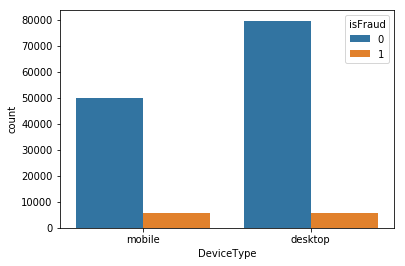

In [24]:
sns.countplot(train['DeviceType'], hue='isFraud', data=train);

Here we see, that the amount of fraud is pretty similar, which is what we can expect, since the 'DeviceType' can be faked, so it is no surprise, that there is no difference.

# Does the Time of Day predict fraud?

Maybe the time of day has something to do with if the transaction is fraud or not. 

The data has a 'TransactionDT' column, that we divide by the total number of seconds in a day. We then define 3600 bins which we put our data into, so that we get the plot below, that shows the difference in number of transactions per time.

Text(0, 0.5, 'Number of transactions')

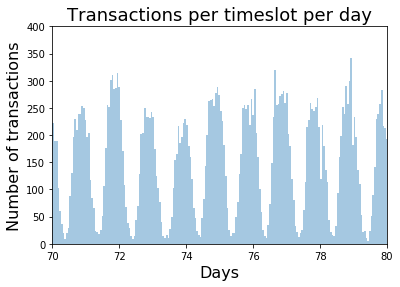

In [25]:
vals = sns.distplot(train['TransactionDT'] / (60*60*24),bins=3600, kde=False)
plt.xlim(70,80)
plt.ylim(0,400)
plt.title('Transactions per timeslot per day', fontsize=18)
plt.xlabel('Days', fontsize=16)
plt.ylabel('Number of transactions', fontsize=16)

As we can see the number of transactions fluctuates quite a bit. Does the same hold true for frauds as well? To answer this we need to divide the 'TransactionDT' into 24 chunks of 1 hour each and we add this new feature to the dataframe (the function is very broad, so the code can be reused in an other project, should a similar situation arise)

In [0]:
def make_hour_feature(df, tname='TransactionDT'):
    """
    Creates an hour of the day feature, encoded as 0-23. 
    
    Parameters:
    -----------
    df : pd.DataFrame
        df to manipulate.
    tname : str
        Name of the time column in df.
    """
    hours = df[tname] / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

Now we can use our new function

In [0]:
train['hours'] = make_hour_feature(train)


And now for some plotting :)

Text(0, 0.5, 'Number of transactions')

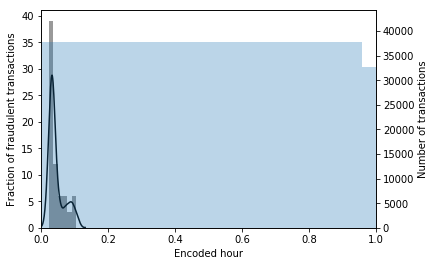

In [31]:
sns.distplot(train.groupby('hours').mean()['isFraud'], color='k')
ax = plt.gca()
ax2 = ax.twinx()
_ = ax2.hist(train['hours'], alpha=0.3, bins=24)
ax2.set_xlim([0,1])
ax.set_xlabel('Encoded hour')
ax.set_ylabel('Fraction of fraudulent transactions')

ax2.set_ylabel('Number of transactions')

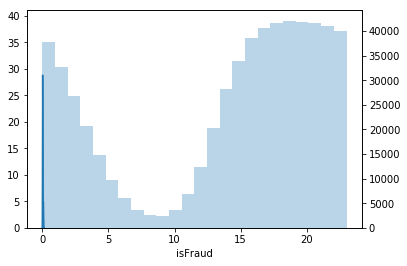

In [34]:
sns.distplot(train.groupby('hours')['isFraud'].mean());
ax = plt.gca()
ax2 = ax.twinx()
_ = ax2.hist(train['hours'], alpha=0.3, bins=24)


# How big is the fraud?

An other interesting thing is to see how big the fraud is and how big a percentage it is.

In [35]:
frauds = train.loc[train['isFraud'] == 1]
non_frauds = train.loc[train['isFraud'] == 0]

print(len(frauds))
print(len(non_frauds))

20663
569877


Next we plot the fraud on a scale to get an idea of how big the fraud amounts are for.

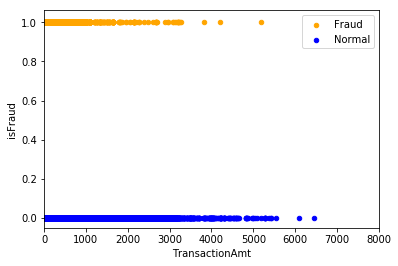

In [36]:
# Plot the fraud and non fraud based on the amount spent
ax = frauds.plot.scatter(x='TransactionAmt', y='isFraud', color='Orange', label='Fraud')
non_frauds.plot.scatter(x='TransactionAmt', y='isFraud', color='Blue', label='Normal', ax=ax)
plt.xlim(0,8000)
plt.show()


As we can see the fraud amounts are all pretty low - going up till about 6000.

# Model training

Now it is time for training the model itself. Here we "just" drop all the colums with at least 1 non-empty value. This will get updated in a later version of this colab, but this gives a quick benchmark.

In [0]:
train.dropna(axis='columns', inplace=True)

In [38]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,hours
0,2987000,0,86400,68.5,W,13926,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0
1,2987001,0,86401,29.0,W,2755,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,2987002,0,86469,59.0,W,4663,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,2987003,0,86499,50.0,W,18132,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,0.0
4,2987004,0,86506,50.0,H,4497,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0


As we can see, there is a column, that has text it in - the ProductCD column. Maybe there are others?  We check this with the following command.

In [40]:
train[train.select_dtypes(include=['object']).columns].head()

,ProductCD
0,W
1,W
2,W
3,W
4,H


We have to get rid of these text. We do this by creating dummy-variables

In [0]:
ProductCD_dummies_df=pd.get_dummies(train["ProductCD"])

In [43]:
ProductCD_dummies_df.head()

,C,H,R,S,W
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,0,0,0,0,1
4,0,1,0,0,0


What we did here was from the one "text" variable we created 5 numerical values that indicate what letter the "ProductCD" column originally had. So we add these new variables to the test-dataframe, and we delete the "colums" that had text in them.

In [0]:
train=pd.concat([train,ProductCD_dummies_df],axis=1)

In [46]:
train=train._get_numeric_data()
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,hours,C,H,R,S,W
0,2987000,0,86400,68.5,13926,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,0,0,0,0,1
1,2987001,0,86401,29.0,2755,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0,0,0,0,1
2,2987002,0,86469,59.0,4663,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0,0,0,0,1
3,2987003,0,86499,50.0,18132,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,0.0,0,0,0,0,1
4,2987004,0,86506,50.0,4497,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0,1,0,0,0


We now split our data into training data to use when our model needs to be trained.

In [53]:
y_training = train['isFraud'].copy()
y_training.head()

0    0
1    0
2    0
3    0
4    0
Name: isFraud, dtype: int8

In [49]:
X_train = train.drop('isFraud', axis=1)
X_train.head()

,TransactionID,TransactionDT,TransactionAmt,card1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,hours,C,H,R,S,W
0,2987000,86400,68.5,13926,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,0.0,0,0,0,0,1
1,2987001,86401,29.0,2755,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0,0,0,0,1
2,2987002,86469,59.0,4663,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0,0,0,0,1
3,2987003,86499,50.0,18132,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,0.0,0,0,0,0,1
4,2987004,86506,50.0,4497,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0,1,0,0,0


In [0]:
X_train,X_test,y_training,y_test=train_test_split(train,y_training, test_size=0.50)

In [0]:
model = LogisticRegression(solver = 'lbfgs' )

In [60]:
model.fit(X_train, y_training)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

How good/accurate is the model?

In [63]:
model.score(X_test, y_test)

0.9648762149896705

Now we want to predict the values.

In [0]:
y_pred = model.predict(X_test)

And now we want to print the confusion matrix, to see how whell the model has performed. 

In [65]:
pd.crosstab(y_test, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,All
True,,
0,284899,284899
1,10371,10371
All,295270,295270


And what is the recall score of the model? ( recall (also known as sensitivity) is the fraction of relevant instances that have been retrieved over the total amount of relevant instances.)

In [66]:
recall_score(y_test, y_pred)

0.0

As one can see the model is not super accurate. This is probably due to dropping all the columns, that had at least 1 "unknown" input in it. BUT this has at least given us a baseline model to improve on.